In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
plt.ion()   # interactive mode
import time
import copy
from torch.optim import lr_scheduler
torch.set_default_dtype(torch.float64)

In [2]:
class TransformerImageDataset(Dataset):
    def __init__(self, theta_dir, img_dir, transform=None,resize_transform=None):
        self.img_dir = img_dir
        self.theta_dir = theta_dir
        
        self.transform = transform
        self.resize_transform= resize_transform
        
        self.dataSetLen = len(os.listdir(img_dir))
        
        
    def __len__(self):
        return self.dataSetLen

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, f"{idx}.jpg")
        theta_path = os.path.join(self.theta_dir, f"{idx}.csv")
        
        image = Image.open(img_path).convert('RGB')
        
        with open(theta_path) as file:
            theta = np.loadtxt(file, delimiter=";")

        if self.transform:
            orig_image = self.transform(image)
        if self.resize_transform:
            image_resize = self.resize_transform(image)
        return orig_image, image_resize, theta

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        #transforms.Grayscale(),
        transforms.ToTensor(),
        #transforms.Lambda(lambda x: x.repeat(3,1,1)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'train_resize': transforms.Compose([
        #transforms.Grayscale(),
        transforms.Resize((56,56)),
        transforms.ToTensor(),
        #transforms.Lambda(lambda x: x.repeat(3,1,1)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        #transforms.Grayscale(),
        transforms.ToTensor(),
        #transforms.Lambda(lambda x: x.repeat(3,1,1)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val_resize': transforms.Compose([
        #transforms.Grayscale(),
        transforms.Resize((56,56)),
        transforms.ToTensor(),
        #transforms.Lambda(lambda x: x.repeat(3,1,1)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
}

training_data = TransformerImageDataset(theta_dir='../input/tongi-ntu-augmented/ThetaLearner-Augmented/train/csvLandmark', img_dir='../input/tongi-ntu-augmented/ThetaLearner-Augmented/train/imgMask', transform=data_transforms['train'],resize_transform=data_transforms['train_resize'])
test_data = TransformerImageDataset(theta_dir='../input/tongi-ntu-augmented/ThetaLearner-Augmented/test/csvLandmark', img_dir='../input/tongi-ntu-augmented/ThetaLearner-Augmented/test/imgMask', transform=data_transforms['val'], resize_transform=data_transforms['val_resize'])

train_dataloader = DataLoader(training_data, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=256, shuffle=True)

In [4]:
len(training_data)

22503

Original batch shape: torch.Size([256, 3, 227, 227])
Cut batch shape: torch.Size([256, 3, 56, 56])
Target Label: torch.Size([256, 18])
Raw-Image:


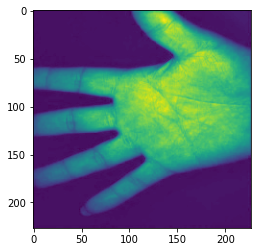

Resized-Image:


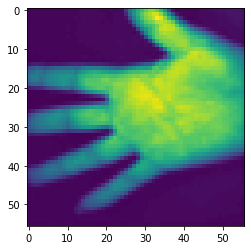

Label:
tensor([ 0.2387,  0.6761,  0.9666, -0.2287,  0.3823,  0.9599, -0.1386,  0.2888,
         0.7963,  0.5259,  0.4424,  0.3656,  0.1252, -0.0317, -0.1519, -0.4524,
        -0.5259, -0.7295])


In [5]:
# Display image and label.
orig_image, image_resize, label = next(iter(train_dataloader))
print(f"Original batch shape: {orig_image.size()}")
print(f"Cut batch shape: {image_resize.size()}")
print(f"Target Label: {label.size()}")
img = orig_image[0]
img_resized = image_resize[0]
label = label[0]
print("Raw-Image:")
plt.imshow(img[0])
plt.show()
print("Resized-Image:")
plt.imshow(img_resized[0])
plt.show()
print("Label:")
print(label)

In [6]:
testTensor = [range(18)]
toTensor = transforms.ToTensor()
testTensor = torch.Tensor(testTensor)
print(testTensor)
print(testTensor.size())
print()
testTensor = testTensor.view(-1, 2, 9)
print(testTensor)
print(testTensor.size())
print()
testTensor = testTensor.view(-1, 18)
print(testTensor)
print(testTensor.size())
print()

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
         14., 15., 16., 17.]])
torch.Size([1, 18])

tensor([[[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.],
         [ 9., 10., 11., 12., 13., 14., 15., 16., 17.]]])
torch.Size([1, 2, 9])

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
         14., 15., 16., 17.]])
torch.Size([1, 18])



In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
class ROILAnet(nn.Module):
    def __init__(self, h=56, w=56, L=18):
        super(ROILAnet, self).__init__()
        self.h = h
        self.w = w
        self.L = L
        vgg16 = models.vgg16(pretrained=True) # load vgg16 with pretrained weights
        vgg16 = vgg16.features # only get feature block
        vgg16 = vgg16[0:18] # cut off after first three conv-blocks
        vgg16[-1] = torch.nn.LocalResponseNorm(512*2, 1e-6, 1, 0.5) #local response normalisation´
        self.featureExtractionCNN = vgg16
        self.featureExtractionCNN.requires_grad = False

        # Regression network
        self.regressionNet = nn.Sequential(
            #nn.Conv3d(int(self.h/8) * int(self.w/8) * 256, 512, (256,7,7)),
            nn.Linear(int(self.h/8) * int(self.w/8) * 256, 512),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(0.2),
            #nn.Conv3d(512, 128, (512,1,1)),
            nn.Linear(512, 128),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(0.1),
            #nn.Conv3d(128, self.L, (128,1,1)),
            nn.Linear(128, self.L)
        )
    
        self.regressionNet.apply(self.init_weights)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight,mean=0.0, std=0.001)
        if isinstance(m, nn.Conv3d):
            nn.init.normal_(m.weight,mean=0.0, std=0.001)      
    
    def forward(self,I_resized):
        # Pass to feature extraction CNN
        feat = self.featureExtractionCNN(I_resized)
        feat  = feat.view(-1, int(self.h/8) * int(self.w/8) * 256)
        # Pass to regression network
        theta = self.regressionNet(feat)
        return theta
    
    def unfreezeVGG(self):
        self.featureExtractionCNN.requires_grad = True

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=80):
    train_lss, val_lss= [], []
    since = time.time() #starting time

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 100.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        if epoch == 10:
            print('Unfreeze VGG')
            model.unfreezeVGG()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for _,inputs_resized, labels in (iter(train_dataloader) if phase == 'train' else iter(test_dataloader)):
                labels = labels.to(device)
                inputs_resized = inputs_resized.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs_resized)
                    #_, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs_resized.size(0)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / (len(training_data) if phase == 'train' else len(test_data))

            #add to lists
            if phase == 'train':
                train_lss.append(epoch_loss)
                #train_acc.append(epoch_acc)
            else:
                val_lss.append(epoch_loss)
                #val_acc.append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} ')

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_lss, val_lss

In [10]:
model = ROILAnet().to(device)

#for param in model_ft.parameters():
#    param.requires_grad = False

criterion = nn.MSELoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 100 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=65, gamma=0.1)

epochs = 70

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [11]:
model, train_lss, val_lss = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=epochs)

torch.save(model.state_dict(), 'ROI_extractor_augmented_TJ-NTU.pt')

Epoch 0/69
----------
train Loss: 0.0528 
val Loss: 0.0108 

Epoch 1/69
----------
train Loss: 0.0113 
val Loss: 0.0055 

Epoch 2/69
----------
train Loss: 0.0081 
val Loss: 0.0069 

Epoch 3/69
----------
train Loss: 0.0071 
val Loss: 0.0046 

Epoch 4/69
----------
train Loss: 0.0068 
val Loss: 0.0045 

Epoch 5/69
----------
train Loss: 0.0061 
val Loss: 0.0043 

Epoch 6/69
----------
train Loss: 0.0058 
val Loss: 0.0039 

Epoch 7/69
----------
train Loss: 0.0056 
val Loss: 0.0046 

Epoch 8/69
----------
train Loss: 0.0055 
val Loss: 0.0038 

Epoch 9/69
----------
train Loss: 0.0053 
val Loss: 0.0035 

Epoch 10/69
----------
Unfreeze VGG
train Loss: 0.0050 
val Loss: 0.0035 

Epoch 11/69
----------
train Loss: 0.0049 
val Loss: 0.0043 

Epoch 12/69
----------
train Loss: 0.0048 
val Loss: 0.0036 

Epoch 13/69
----------
train Loss: 0.0047 
val Loss: 0.0030 

Epoch 14/69
----------
train Loss: 0.0046 
val Loss: 0.0041 

Epoch 15/69
----------
train Loss: 0.0045 
val Loss: 0.0028 

Epoch

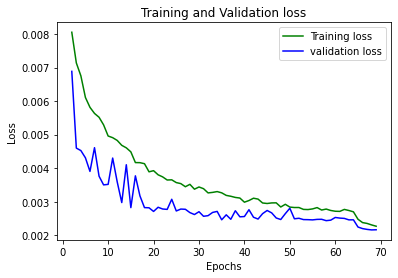

In [12]:
epochs = range(2,epochs)
plt.plot(epochs, train_lss[2:], 'g', label='Training loss')
plt.plot(epochs, val_lss[2:], 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')
plt.show()